# Experiment Analysis

This notebook is used to analyze the results of certain experiments which can be found in the pycomex experiment archive located at the ``RESULTS_PATH`` directory.

In [13]:
%matplotlib inline
import os
import time
import json
import datetime
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Latex
from rich.pretty import pprint
from pycomex.utils import is_experiment_archive
from pycomex.utils import render_string_table
from pycomex.functional.experiment import Experiment

# This will be the path to the directory in which the notebook is located.
PATH: str = os.getcwd()
# This will have to be the path to the pycomex "results" directory containing the 
# experiment archives of interest.
# HAS TO BE CHANGED, if the analysis is not located in the same directory as the results
# folder.
RESULTS_PATH: str = os.path.join(PATH, 'results')

In [14]:
# Filter which experiments will be loaded based on their name and/or parameters.
def select_experiment(experiment_name: str,
                      experiment_metadata: dict,
                      experiment_parameters: dict
                      ) -> bool:
    main_condition = 'ex_03_ae' in experiment_parameters.get('__PREFIX__', '')
    return main_condition


# Assign a unique key to the experiment based on its data / parameters etc.
# Later on the experiments will be sorted based on this key which will be the 
# key of a dictionary and the values will be a list of all the experiments with 
# that same key.
def sort_experiment(experiment: Experiment) -> tuple:
    *_, encoding, dataset = experiment.metadata['name'].split('__')
    method = experiment.parameters['MODELS'][0]
    num_train = experiment.parameters['NUM_TRAIN']
    
    if 'EMBEDDING_SIZE' in experiment.parameters:
        embedding_size = experiment.parameters['EMBEDDING_SIZE']
    else:
        embedding_size = experiment.parameters['FINGERPRINT_SIZE']
    
    if 'NUM_LAYERS' in experiment.parameters:
        embedding_depth = experiment.parameters['NUM_LAYERS']
    else:
        embedding_depth = experiment.parameters['FINGERPRINT_RADIUS']
        
    if '_fp' in experiment.metadata['name']:
        encoding = 'fp'
    elif '_hdc' in experiment.metadata['name']:
        encoding = 'hdc'
    elif '_gnn' in experiment.metadata['name']:
        encoding = 'gnn'
    
    return (encoding, method, embedding_size, embedding_depth)

### Experiment Discovery

The following cell will first discover all of the previously executed experiment runs which have been archived in the given results directory. It will then print the number of experiments found.

In [15]:
# This list will contain the paths to the individual expeirment *namespaces* which in 
# turn contain the actual individual experiment archives.
experiment_namespace_paths: list[str] = [
    path
    for file_name in os.listdir(RESULTS_PATH)
    if os.path.isdir(path := os.path.join(RESULTS_PATH, file_name))
]

# Subsequently, this list will contain the paths to the individual experiment archives
# folders.
experiment_paths: list[str] = []
for namespace_path in experiment_namespace_paths:
    for dirpath, dirnames, filenames in os.walk(namespace_path):
        if is_experiment_archive(dirpath):
            experiment_paths.append(dirpath)
            dirnames.clear() # Prevents further recursion into subdirectories
        
print(f'✅ found {len(experiment_paths)} experiment archives in {len(experiment_namespace_paths)} namespaces')
pprint(experiment_paths, max_length=3)

✅ found 37331 experiment archives in 61 namespaces


[
│   '/media/ssd2/Programming/graph_hdc/graph_hdc/experiments/fingerprints/results/predict_molecules__hdc__bace/ex_01_a__10_01_2025__18_29__6zGY',
│   '/media/ssd2/Programming/graph_hdc/graph_hdc/experiments/fingerprints/results/predict_molecules__hdc__bace/debug',
│   '/media/ssd2/Programming/graph_hdc/graph_hdc/experiments/fingerprints/results/predict_molecules__hdc__bace/ex_01_a__10_01_2025__18_32__Sozn',
│   ... +37328
]

### Experiment Loading

The following cell will then load the experiment runs into memory selectively based on the previously defined ``select_experiment`` function. Only experiments for which the function returns ``True`` will be loaded into memory. The loaded experiments will actually be restored from the archive by loading the parameters as well as the data back into a ``pycomex.experiment.Experiment`` object.

In [16]:
# This list will be populated with the actual Experiment instances which will 
# be loaded from the experiment archive folders.
experiments: list[Experiment] = []

print('Loading experiments from archives...')
time_start: float = time.time()
for experiment_path in experiment_paths:
    
    experiment_identifier: str = os.path.basename(experiment_path)
    
    experiment_data_path = os.path.join(experiment_path, Experiment.DATA_FILE_NAME)
    if not os.path.exists(experiment_data_path):
        print(f'   ⚠️ Skipping experiment "{experiment_identifier}" - no data found')
        continue
    
    experiment_meta_path = os.path.join(experiment_path, Experiment.METADATA_FILE_NAME)
    if not os.path.exists(experiment_meta_path):
        print(f'   ⚠️ Skipping experiment "{experiment_identifier}" - no metadata found')
        continue
    
    with open(experiment_meta_path) as file:
        content = file.read()
        # This will contain the experiment metadata as a dictionary which we can now use to
        # filter for instance.
        experiment_metadata: dict = json.loads(content)
        
    if 'parameters' not in experiment_metadata:
        print(f'   ⚠️ Skipping experiment "{experiment_identifier}" - no parameters found')
        continue
    
    experiment_parameters: dict = {
        param: info['value']
        for param, info in experiment_metadata['parameters'].items()
        if 'value' in info
    }
    
    # Here we apply the filter to determine whether or not the experiment should be included
    # in the analysis.
    condition: bool = select_experiment(
        experiment_name=experiment_metadata['name'],
        experiment_metadata=experiment_metadata,
        experiment_parameters=experiment_parameters
    )
    
    if condition:
        try:
            print(f'   > included experiment "{experiment_identifier}"')
            experiment: Experiment = Experiment.load(experiment_path)
            experiments.append(experiment)
        except Exception as e:
            print(f'   ⚠️ Failed to load experiment "{experiment_identifier}" - Exception: {e}')
            
time_end: float = time.time()
duration: float = time_end - time_start
print(f'✅ Loaded {len(experiments)} experiments in {duration:.2f} seconds')

Loading experiments from archives...
   ⚠️ Skipping experiment "debug" - no data found
   ⚠️ Skipping experiment "ex_00_c__17_08_2025__16_08__JXbr" - no data found
   ⚠️ Skipping experiment "debug" - no data found
   ⚠️ Skipping experiment "debug" - no data found
   ⚠️ Skipping experiment "debug" - no data found
   ⚠️ Skipping experiment "debug" - no data found
   ⚠️ Skipping experiment "ex_04_e__15_01_2025__09_00__MnVH" - no data found
   ⚠️ Skipping experiment "debug" - no data found
   ⚠️ Skipping experiment "debug" - no data found
   ⚠️ Skipping experiment "ex_04_ad__11_09_2025__20_43__hJiq" - no data found
   ⚠️ Skipping experiment "ex_04_d__06_08_2025__13_15__ja1g" - no data found
   ⚠️ Skipping experiment "hyperopt_b__16_01_2025__08_56__Cv1n" - no data found
   ⚠️ Skipping experiment "ex_06_a__31_10_2025__21_53__78nN" - no data found
   ⚠️ Skipping experiment "debug" - no data found
   ⚠️ Skipping experiment "ex_03_b__31_07_2025__11_49__M1Nv" - no data found
   ⚠️ Skipping exper

In [17]:
example_experiment: Experiment = experiments[0] if experiments else None
pprint(example_experiment.data, max_length=10)

{
│   'indices': {
│   │   'train': [597, 1244, 1020, 241, 202, 288, 934, 1312, 1110, 1062, ... +1216],
│   │   'val': [139, 145, 131, 378, 1367, 334, 1390, 96, 1258, 1129, ... +126],
│   │   'test': [688, 419, 338, 223, 1101, 442, 1116, 1021, 744, 364, ... +141]
│   },
│   'metrics': {
│   │   'test_k_neighbors': {'r2': -0.09797827709899787, 'mse': 2.0257128307107926, 'mae': 1.1308361749668874}
│   }
}

### Experiment Sorting

The following cell will sort the - currently still unsorted - experiment list by a custom criteria defined in the ``sort_experiments`` function. This is done by putting all the experiments into the same list for which this function returns the same index tuple. The result is the ``key_experiment_map`` dictionary data structure which maps the index tuple to a list of experiments.

In [18]:
# This will be a dictionary mapping the unique key of the experiment to a list of
# experiments which share that key. This will allow us to group experiments based on
# their parameters or other attributes.
key_experiment_map: dict[tuple, list[Experiment]] = defaultdict(list)

for experiment in experiments:
    key: tuple = sort_experiment(experiment)
    key_experiment_map[key].append(experiment)
    
key_experiment_map = dict(sorted(key_experiment_map.items(), key=lambda item: item[0][0] + item[0][1] + str(item[0][3]) + f'{item[0][2]:05d}'))
    
pprint(key_experiment_map, max_length=3)

{
│   ('fp', 'k_neighbors', 8, 1): [
│   │   <pycomex.functional.experiment.Experiment object at 0x7191a79396d0>,
│   │   <pycomex.functional.experiment.Experiment object at 0x7191aa4061d0>,
│   │   <pycomex.functional.experiment.Experiment object at 0x7191a7029a90>,
│   │   ... +2
│   ],
│   ('fp', 'k_neighbors', 16, 1): [
│   │   <pycomex.functional.experiment.Experiment object at 0x7191a6478550>,
│   │   <pycomex.functional.experiment.Experiment object at 0x7191a5e70c10>,
│   │   <pycomex.functional.experiment.Experiment object at 0x7191a5905410>,
│   │   ... +2
│   ],
│   ('fp', 'k_neighbors', 32, 1): [
│   │   <pycomex.functional.experiment.Experiment object at 0x7191a6258190>,
│   │   <pycomex.functional.experiment.Experiment object at 0x7191a6128790>,
│   │   <pycomex.functional.experiment.Experiment object at 0x7191a5b1a010>,
│   │   ... +2
│   ],
│   ... +141
}

### Experiment Result Table

The following cell illustrates how to create a table from the aggregated results of many loaded experiments, which is a common use case of the analysis.

In [19]:
from prettytable import PrettyTable

table = PrettyTable()
table.field_names = ['Encoding', 'Method', 'Emb. Depth', 'Emb. Size', 'Result']

# This data structure will hold the (encoding, dataset, method) tuple as keys and the metric
# values as a list value.
key_values_map = defaultdict(list)

for (encoding, method, emb_size, emb_depth), _experiments in key_experiment_map.items():
    
    example_experiment = _experiments[0]
    if example_experiment.parameters['DATASET_TYPE'] == 'regression':
        metric = 'mse'
    else:
        metric = 'f1'
        
    values = [exp.data['metrics'][f'test_{method}'][metric] for exp in _experiments if 'metrics' in exp.data]
    mean_value = np.mean(values)
    std_value = np.std(values)
    
    table.add_row([
        encoding,
        method,
        emb_depth,
        emb_size,
        f'{mean_value:.2f} ± {std_value:.2f}',
    ])
    
    key_values_map[(encoding, method, emb_size, emb_depth)] = values
    
print(table.get_string())

+----------+-------------+------------+-----------+-------------+
| Encoding |    Method   | Emb. Depth | Emb. Size |    Result   |
+----------+-------------+------------+-----------+-------------+
|    fp    | k_neighbors |     1      |     8     | 2.24 ± 0.41 |
|    fp    | k_neighbors |     1      |     16    | 1.81 ± 0.38 |
|    fp    | k_neighbors |     1      |     32    | 0.87 ± 0.24 |
|    fp    | k_neighbors |     1      |     64    | 0.72 ± 0.18 |
|    fp    | k_neighbors |     1      |    128    | 0.71 ± 0.19 |
|    fp    | k_neighbors |     1      |    256    | 0.70 ± 0.18 |
|    fp    | k_neighbors |     1      |    512    | 0.70 ± 0.19 |
|    fp    | k_neighbors |     1      |    1024   | 0.69 ± 0.20 |
|    fp    | k_neighbors |     1      |    2048   | 0.69 ± 0.19 |
|    fp    | k_neighbors |     1      |    4096   | 0.68 ± 0.18 |
|    fp    | k_neighbors |     1      |    8192   | 0.69 ± 0.19 |
|    fp    | k_neighbors |     1      |   16384   | 0.69 ± 0.18 |
|    fp   

fp neural_net2 1
fp neural_net2 3
hdc neural_net2 1
hdc neural_net2 3


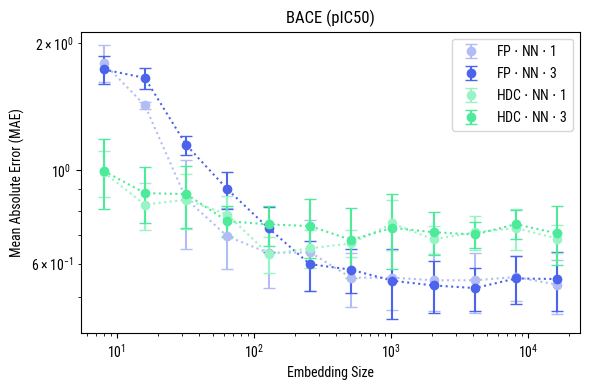

In [23]:
"""
Visualization: Embedding Size Analysis

This cell creates a log-log plot showing how model performance scales with embedding size
for different encoding methods (Fingerprints, HDC) and prediction models (Neural Net, Random Forest).
The plot helps identify the optimal embedding dimensions and how different methods compare
across various dimensionalities.
"""

# ============================================================================
# CONFIGURATION
# ============================================================================

# Select which embedding depths to visualize
DEPTHS: list[int] = [1, 3]  # Show depth 1 and 3 only

# Select which prediction method to visualize
METHOD: str = 'neural_net2'  # Can be: 'neural_net', 'neural_net2', 'random_forest', 'k_neighbors'

# Figure size configuration (width, height) in inches
FIGSIZE: tuple[int, int] = (6, 4)

# Font size for all text elements in the plot
FONT_SIZE: int = 10

# Exclude specific (encoding, method) combinations from the visualization
EXCLUDE_METHODS: list[tuple] = [
    # ('fp', 'neural_net2'),
    # ('fp', 'random_forest'),
    # ('fp', 'k_neighbors'),
    # ('hdc', 'neural_net2'),
    # ('hdc', 'random_forest'),
    # ('hdc', 'k_neighbors'),
]


# ============================================================================
# IMPORTS AND PLOT SETUP
# ============================================================================

import numpy as np
import matplotlib.pyplot as plt

# Apply default matplotlib style
plt.style.use('default')

# Use Roboto Condensed font for consistent typography
plt.rcParams['font.family'] = 'Roboto Condensed'
plt.rcParams['font.size'] = FONT_SIZE

# Create figure with appropriate size for publication/presentation
plt.figure(figsize=FIGSIZE)


# ============================================================================
# VISUAL MAPPINGS: LABELS AND COLORS
# ============================================================================

# Human-readable labels for each (encoding, method, depth) combination
# These labels will appear in the plot legend
key_label_map = defaultdict(lambda: 'Unknown Method')
key_label_map.update({
    ('fp', 'neural_net', 1): 'FP $\cdot$ NN $\cdot$ 1',
    ('fp', 'neural_net', 2): 'FP $\cdot$ NN $\cdot$ 2',
    ('fp', 'neural_net', 3): 'FP $\cdot$ NN $\cdot$ 3',
    ('fp', 'neural_net2', 1): 'FP $\cdot$ NN $\cdot$ 1',
    ('fp', 'neural_net2', 2): 'FP $\cdot$ NN $\cdot$ 2',
    ('fp', 'neural_net2', 3): 'FP $\cdot$ NN $\cdot$ 3',
    ('fp', 'random_forest', 1): 'FP $\cdot$ RF $\cdot$ 1',
    ('fp', 'random_forest', 2): 'FP $\cdot$ RF $\cdot$ 2',
    ('fp', 'random_forest', 3): 'FP $\cdot$ RF $\cdot$ 3',
    ('fp', 'k_neighbors', 1): 'FP $\cdot$ KNN $\cdot$ 1',
    ('fp', 'k_neighbors', 2): 'FP $\cdot$ KNN $\cdot$ 2',
    ('fp', 'k_neighbors', 3): 'FP $\cdot$ KNN $\cdot$ 3',
    ('hdc', 'neural_net', 1): 'HDC $\cdot$ NN $\cdot$ 1',
    ('hdc', 'neural_net', 2): 'HDC $\cdot$ NN $\cdot$ 2',
    ('hdc', 'neural_net', 3): 'HDC $\cdot$ NN $\cdot$ 3',
    ('hdc', 'neural_net2', 1): 'HDC $\cdot$ NN $\cdot$ 1',
    ('hdc', 'neural_net2', 2): 'HDC $\cdot$ NN $\cdot$ 2',
    ('hdc', 'neural_net2', 3): 'HDC $\cdot$ NN $\cdot$ 3',
    ('hdc', 'random_forest', 1): 'HDC $\cdot$ RF $\cdot$ 1',
    ('hdc', 'random_forest', 2): 'HDC $\cdot$ RF $\cdot$ 2',
    ('hdc', 'random_forest', 3): 'HDC $\cdot$ RF $\cdot$ 3',
    ('hdc', 'k_neighbors', 1): 'HDC $\cdot$ KNN $\cdot$ 1',
    ('hdc', 'k_neighbors', 2): 'HDC $\cdot$ KNN $\cdot$ 2',
    ('hdc', 'k_neighbors', 3): 'HDC $\cdot$ KNN $\cdot$ 3',
})

# Color scheme for different encoding-method-depth combinations
# Blue shades for Fingerprint methods
# Green shades for HDC methods
key_color_map = defaultdict(lambda: '#000000')  # Default black if not specified
key_color_map.update({
    ('fp', 'neural_net', 1): '#B2BDF6',
    ('fp', 'neural_net', 2): '#7C92FF',
    ('fp', 'neural_net', 3): '#4C64EB',
    ('fp', 'neural_net2', 1): '#B2BDF6',
    ('fp', 'neural_net2', 2): '#7C92FF',
    ('fp', 'neural_net2', 3): '#4C64EB',
    ('fp', 'random_forest', 1): '#B2BDF6',
    ('fp', 'random_forest', 2): '#7C92FF',
    ('fp', 'random_forest', 3): '#4C64EB',
    ('fp', 'k_neighbors', 1): '#B2BDF6',
    ('fp', 'k_neighbors', 2): '#7C92FF',
    ('fp', 'k_neighbors', 3): '#4C64EB',
    ('hdc', 'neural_net', 1): '#99F4C5',
    ('hdc', 'neural_net', 2): '#69F7AE',
    ('hdc', 'neural_net', 3): '#4CEB99',
    ('hdc', 'neural_net2', 1): '#99F4C5',
    ('hdc', 'neural_net2', 2): '#69F7AE',
    ('hdc', 'neural_net2', 3): '#4CEB99',
    ('hdc', 'random_forest', 1): '#99F4C5',
    ('hdc', 'random_forest', 2): '#69F7AE',
    ('hdc', 'random_forest', 3): '#4CEB99',
    ('hdc', 'k_neighbors', 1): '#99F4C5',
    ('hdc', 'k_neighbors', 2): '#69F7AE',
    ('hdc', 'k_neighbors', 3): '#4CEB99',
})


# ============================================================================
# DATA PREPARATION
# ============================================================================

# Group experiments by (encoding, method, emb_depth), collecting all embedding_size values and their results
# This transforms the flat key_values_map into a hierarchical structure suitable for line plots
grouped = defaultdict(list)
for (encoding, method, emb_size, emb_depth), vals in key_values_map.items():
    grouped[(encoding, method, emb_depth)].append((emb_size, vals))


# ============================================================================
# PLOTTING: ERROR BARS AND TREND LINES
# ============================================================================

for (encoding, method, emb_depth), items in grouped.items():
    
    # Skip methods not matching the selected METHOD
    if method != METHOD:
        continue
    
    # Skip depths not in the selected DEPTHS list
    if emb_depth not in DEPTHS:
        continue
    
    # Skip excluded method combinations
    if (encoding, method) in EXCLUDE_METHODS:
        continue
    
    # Sort data points by embedding size for proper line plotting
    items = sorted(items, key=lambda x: x[0])
    
    # Extract x-values (embedding sizes), means, and standard deviations
    embedding_sizes = np.array([emb_size for emb_size, _ in items])
    means = np.array([np.mean(vals) for _, vals in items])
    stds = np.array([np.std(vals) for _, vals in items])

    # Get human-readable label and color for this method
    print(encoding, method, emb_depth)
    label = key_label_map[(encoding, method, emb_depth)]
    color = key_color_map[(encoding, method, emb_depth)]
    
    # Plot error bars showing mean ± std for each embedding size
    plt.errorbar(embedding_sizes, means, yerr=stds, fmt='o', label=label, color=color, capsize=4)

    # Connect points with dotted lines to show the scaling trend
    plt.plot(embedding_sizes, means, color=color, linestyle=':')


# ============================================================================
# METADATA EXTRACTION
# ============================================================================

# Extract experiment configuration details from a representative experiment
# This information is used for the plot title
example_experiment = experiments[0]

# Get dataset name
dataset = example_experiment.parameters['DATASET_NAME']
if 'NOTE' in example_experiment.parameters:
    dataset = example_experiment.parameters['NOTE']

# Human-readable dataset names
dataset_label_map = {
    'aqsoldb': 'AqSolDB',
    'qm9_smiles': 'QM9 (GAP)',
    'qm9_energy': 'QM9 ($U_0$)',
    'qm9_gap': 'QM9 (GAP)',
    'hopv15_gap': 'HOPV15 (GAP)',
    'bace_ic50': 'BACE (pIC50)',
    'lipop': 'LIPOP (logD)',
}


# ============================================================================
# AXIS CONFIGURATION AND DISPLAY
# ============================================================================

# Use log-log scale to visualize power-law scaling relationships
plt.xscale('log')
plt.yscale('log')

# Set axis labels
plt.xlabel('Embedding Size')
plt.ylabel('Mean Absolute Error (MAE)')

# Create informative title with experiment details
plt.title(f'{dataset_label_map.get(dataset, dataset)}')

# Add legend to distinguish different methods
plt.legend()

# Optimize layout to prevent label clipping
plt.tight_layout()

# Display the plot
plt.show()


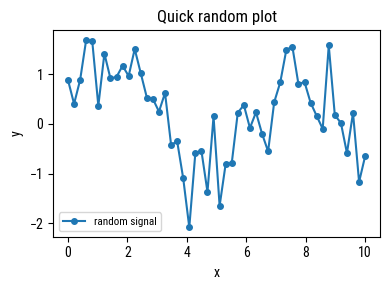

In [ ]:
# Quick random check plot (uses existing `np` and `plt` from earlier cells)
np.random.seed(0)
x = np.linspace(0, 10, 50)
y = np.sin(x) + 0.5 * np.random.randn(x.size)

plt.figure(figsize=(4, 3))
plt.plot(x, y, '-o', markersize=4, label='random signal')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Quick random plot')
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()